# Problem 1 - Build Convolution Neural Network With Lenet Model

In [1]:
import tensorflow as tf 
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
from imutils import paths # list all relative image path


from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

## Download datasets

In [45]:
!pip install GitPython
from git import Repo

In [65]:
try:
  filepath = "concrete-crack-dataset"
  Repo.clone_from('https://github.com/bimewok/Concrete-Crack-Image-Classifier', filepath)
  # 500 MB of photos
except:
  print("Data already exists")

Data already exists


In [2]:
base_dir = 'concrete-crack-dataset/data/concrete_images/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val') 
test_dir = os.path.join(base_dir, 'test') 

## Check whether data is imbalanced?

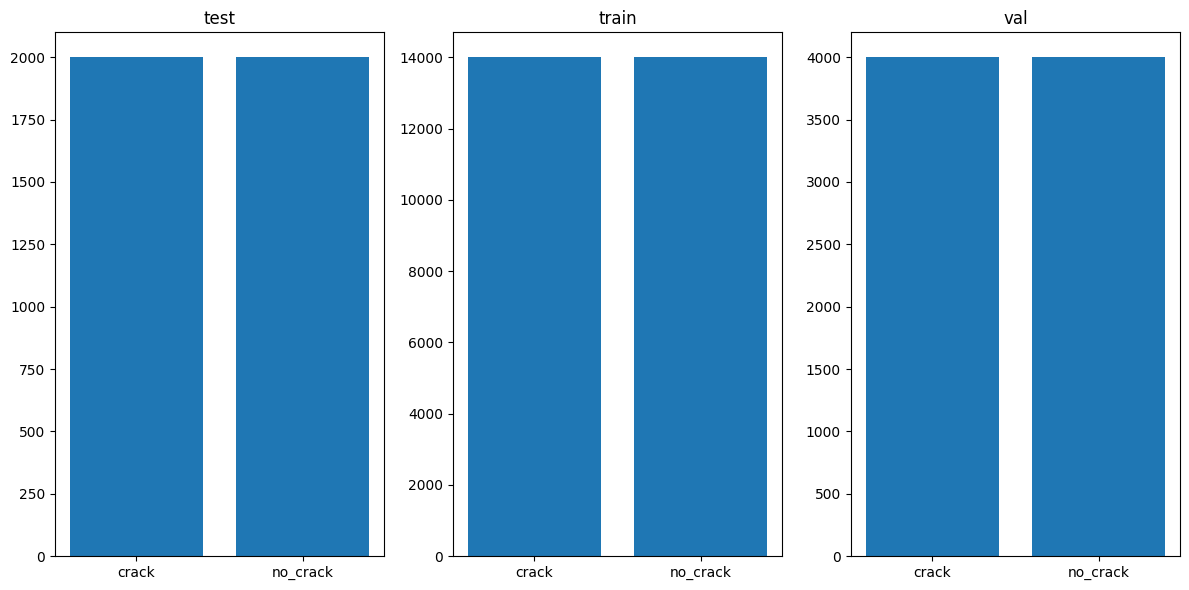

In [3]:
def show_labels(data_dir):
    data = os.listdir(data_dir)
    fig, ax = plt.subplots(1, len(data), figsize=(12,6))
    for idx in range(len(data)):
        sub_dir = os.path.join(data_dir, data[idx])
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(data[idx])
        # ax[idx].axis('off')
    plt.tight_layout()
    plt.show()
    
show_labels(base_dir)

## Discover dataset

In [4]:
def plot_images(data_dir, label, nrows = 3, ncols = 3):
    """
    Display  `nrows*ncols` images randomly from data_dir folder
    """

    data_dir = os.path.join(data_dir, label)

    image_files = list(paths.list_images(data_dir))
    if len(image_files) == 0:
        print("Does not exist this label. Check again!")
        return 
    fig = plt.figure(figsize = (nrows*ncols -1, nrows*ncols -1))

    for i in range(1, nrows*ncols + 1):
        sample_idx = tf.random.uniform((1,1), maxval=len(image_files), dtype= tf.dtypes.int32).numpy().item() # lấy ngẫu nhiên các mẫu trong dữ liệu
        img = plt.imread(image_files[sample_idx])
        size_image = img.shape
        fig.add_subplot(nrows, ncols, i)
        plt.axis("off")
        plt.imshow(img.squeeze())

    fig.suptitle(label + " " + str(size_image), fontweight = 'bold') 
    plt.tight_layout()

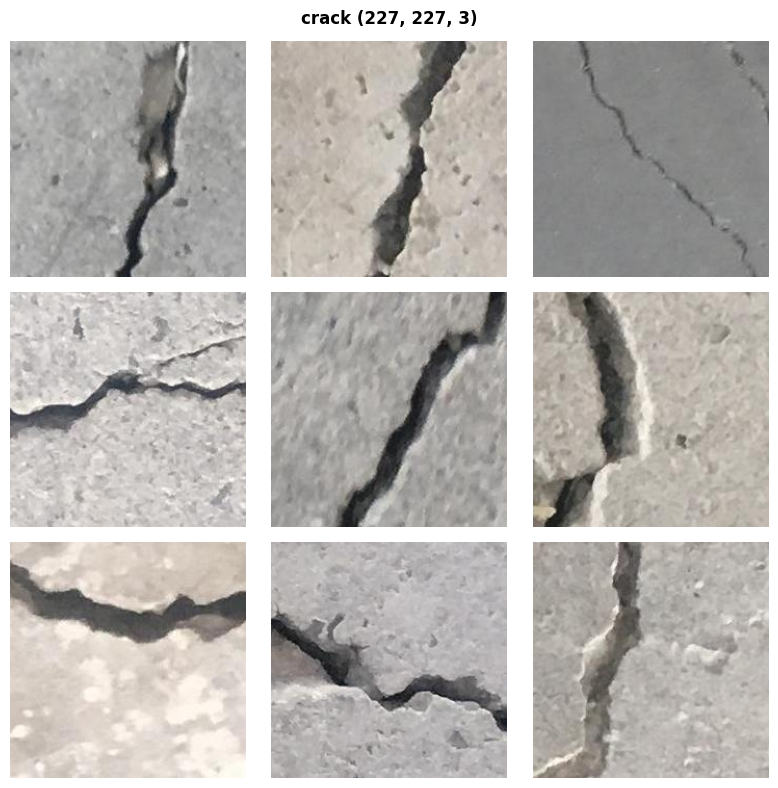

In [50]:
plot_images(train_dir, label="crack")

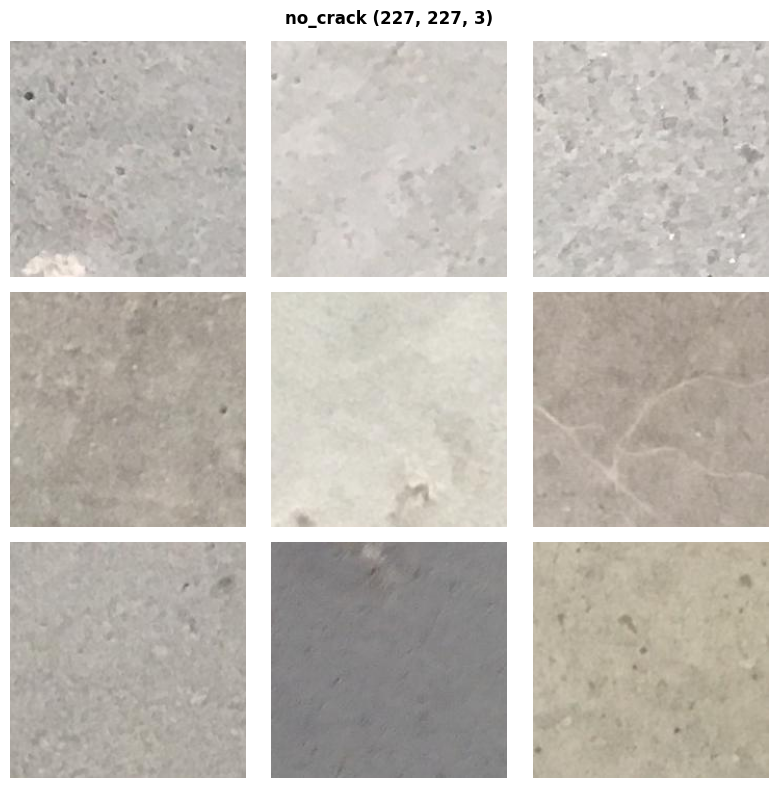

In [51]:
plot_images(train_dir, label="no_crack")


## Preprocessing

ImageDataGenerator allows us to transform original image into different images through tuning parameters of this class. This is technique called Data Augmentation.  
- it is designed to provide real-time data augmentation.
- it only returns the transformed images and does not add it to the original corpus of images
- it requires lower memory usage. Without using this class, we load all images at once whereas we will load the images in batches which saves alot of memory. \

This project, I will use it to normalize image data to 0-1.

In [5]:
img_size = 227
output_size = 1 # binary classification
batch_size = 256 

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

flow_from_directory() is a method of ImageDataGenerator class. It reads the images directly from the directory and augment them while the neural network model is learning on the training data

In [6]:
train_dataloader = train_datagen.flow_from_directory(train_dir, 
                                                     class_mode = 'binary', 
                                                     batch_size = batch_size, 
                                                     target_size= (img_size, img_size))
valid_dataloader = val_datagen.flow_from_directory(val_dir, 
                                         class_mode='binary', 
                                         batch_size=batch_size, 
                                         target_size=(img_size, img_size))

test_dataloader = test_datagen.flow_from_directory(test_dir, 
                                           class_mode='binary', 
                                           batch_size=batch_size, 
                                           target_size=(img_size, img_size))

Found 28000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## LeNet model

In [9]:
lenet_model = tf.keras.models.Sequential([
    # tf.keras.layers.Input(shape = (227, 227, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (img_size, img_size, 3), name = "C1"), 
    #padding = same: want (width, height) of input = (width, height) of output of layer 1 
    tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2, name = "S2"),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, activation = 'relu', name = "C3"), 
    tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2, name = "S4"), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation = 'relu', name = "C5"), 
    tf.keras.layers.Dense(84, activation = 'relu', name = "F6"), 
    tf.keras.layers.Dense(output_size, activation = 'sigmoid') # Output layer    
])

In [55]:
# lenet_model = tf.keras.models.Sequential()
# lenet_model.add(tf.keras.Input(shape = (227, 227,3)))
# lenet_model.add(tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, activation = 'relu', padding = 'same'))
# lenet_model.add(tf.keras.layers.AvgPool2D(pool_size = 2, strides = 2, name = "S2"))


In [10]:
lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 227, 227, 6)       456       
                                                                 
 S2 (AveragePooling2D)       (None, 113, 113, 6)       0         
                                                                 
 C3 (Conv2D)                 (None, 109, 109, 16)      2416      
                                                                 
 S4 (AveragePooling2D)       (None, 54, 54, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 C5 (Dense)                  (None, 120)               5598840   
                                                                 
 F6 (Dense)                  (None, 84)               

In [56]:
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 227, 227, 6)       456       
                                                                 
 S2 (AveragePooling2D)       (None, 113, 113, 6)       0         
                                                                 
 C3 (Conv2D)                 (None, 109, 109, 16)      2416      
                                                                 
 S4 (AveragePooling2D)       (None, 54, 54, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 C5 (Dense)                  (None, 120)               5598840   
                                                                 
 F6 (Dense)                  (None, 84)               

- Keyword "None" above is batch size undefined. It will be defined when compile model.
- padding = same: shape of input = shape of output when going through a layer.

In [57]:
# img_file = "./img_file/lenet_model.png"
# tf.keras.utils.plot_model(lenet_model, to_file = img_file, show_shapes = True, show_layer_names = True)

In [58]:
lenet_model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ['accuracy'])
lenet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 227, 227, 6)       456       
                                                                 
 S2 (AveragePooling2D)       (None, 113, 113, 6)       0         
                                                                 
 C3 (Conv2D)                 (None, 109, 109, 16)      2416      
                                                                 
 S4 (AveragePooling2D)       (None, 54, 54, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 C5 (Dense)                  (None, 120)               5598840   
                                                                 
 F6 (Dense)                  (None, 84)               

- Checkpoint deep learning model is important, cause training model can take many hours, if the run is stopped unexpectedly, you can lose a lot of work.
- The ModelCheckpoint callback class allow you to save models parameter or weights after every epoch.

In [59]:
filepath = "./save_model/lenet_concrete_crack.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath, # name of model at each checkpoint moment
    monitor='val_accuracy', 
    save_best_only=True, # only save best model at checkpoint moment
    save_weights_only=True, # only save weights to save memory
    save_freq='epoch', # Checkpoint after every epoch
    mode='max', # Val_acc go up, means the model is better. Monitor='loss/val_loss' go down, model is better.
    verbose=1 # Display information when checkpoint model
)

Use `EarlyStopping` to save training time

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

Reduce `learning_rate` following training time.

In [61]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           patience = 2, verbose = 1,
                                                           factor = .5, min_lr = 0.00001)

In [62]:
num_epochs = 10
history = lenet_model.fit(train_dataloader,
                        epochs = num_epochs,
                        validation_data = valid_dataloader,
                        callbacks=[model_checkpoint, early_stopping, learning_rate_reduction])

Epoch 1/10
110/110 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8325
Epoch 00001: val_accuracy improved from -inf to 0.97600, saving model to ./save_model\lenet_concrete_crack.h5
110/110 [==============================] - 147s 1s/step - loss: 0.3858 - accuracy: 0.8325 - val_loss: 0.0783 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9842
Epoch 00002: val_accuracy did not improve from 0.97600
110/110 [==============================] - 57s 519ms/step - loss: 0.0525 - accuracy: 0.9842 - val_loss: 0.0747 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9890
Epoch 00003: val_accuracy did not improve from 0.97600

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 [==============================] - 32s 294ms/step - loss: 0.0374 - accuracy: 0.9890 - val_loss: 0.0640 - val_ac

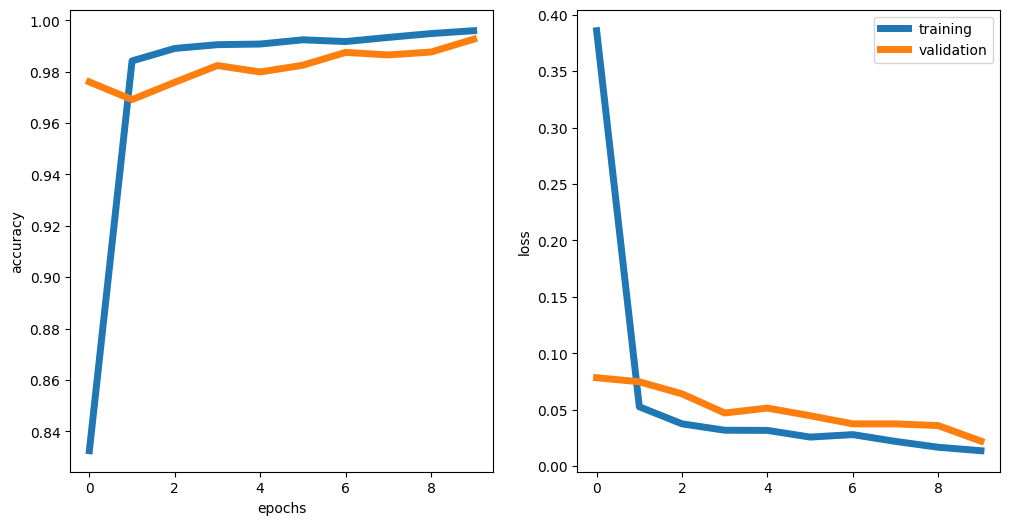

In [63]:
fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
axs[0].plot(range(len(lenet_model.history.history['accuracy'])), lenet_model.history.history['accuracy'], linewidth = 5, label = "training")
axs[0].plot(range(len(lenet_model.history.history['accuracy'])), lenet_model.history.history['val_accuracy'], linewidth = 5, label = "validation")
axs[1].plot(range(len(lenet_model.history.history['loss'])), lenet_model.history.history['loss'], linewidth = 5, label = "training")
axs[1].plot(range(len(lenet_model.history.history['loss'])), lenet_model.history.history['val_loss'], linewidth = 5, label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")
axs[1].set_ylabel("loss")
plt.legend()

# Evaluating performance of lenet model

In [64]:
lenet_model.load_weights("./save_model/lenet_concrete_crack.h5")
loss, accuracy = lenet_model.evaluate(test_dataloader, steps=len(test_dataloader), verbose=1)

16/16 [==============================] - 18s 1s/step - loss: 0.0126 - accuracy: 0.9960
